In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [69]:
# creating and inspecting the dataframe
df = pd.read_csv('abalone.csv')
df.columns = ['Sex', 'Length', 'Diameter', 
              'Height', 'Whole_weight', 'Shucked_weight', 
              'Viscera_weight', 'Shell_weight', 'Rings']
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


## Feature Engineering

In [70]:
# Creating a column for Adult(yes or no) which will be my outcome variable
df['Adult'] = 1
df.loc[
    (df['Sex']== 'I'),
    'Adult'
] = 0

# Up until 21 rings the majority of abalones are I rather than M or F, this will be another feature
df['Ring_Count_<_7'] = 1
df.loc[
    (df['Rings'] > 7),
    'Ring_Count_<_7'
] = 0

In [71]:
df.groupby('Adult')['Ring_Count_<_7'].value_counts()

Adult  Ring_Count_<_7
0      0                  694
       1                  648
1      0                 2643
       1                  191
Name: Ring_Count_<_7, dtype: int64

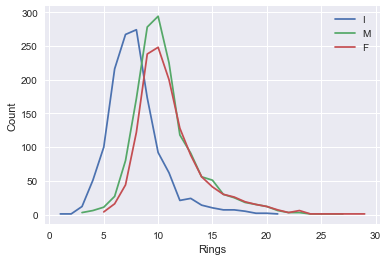

In [72]:
#Exploring if the Rings variable is noticeably different between the sexes
XI = sorted(df.loc[
    (df['Sex'] == 'I'),
    'Rings'
].unique())

XM = sorted(df.loc[
    (df['Sex'] == 'M'),
    'Rings'
].unique())

XF = sorted(df.loc[
    (df['Sex'] == 'F'),
    'Rings'
].unique())

YI = df.loc[
    (df['Sex'] == 'I'),
].groupby('Rings')['Rings'].value_counts()

YM = df.loc[
    (df['Sex'] == 'M'),
].groupby('Rings')['Rings'].value_counts()

YF = df.loc[
    (df['Sex'] == 'F'),
].groupby('Rings')['Rings'].value_counts()

plt.plot(XI, YI, XM, YM, XF, YF)
plt.xlabel('Rings')
plt.ylabel('Count')
plt.legend(['I', 'M', 'F'])
plt.show()

# Creating the regression models

## Regular logistic regression (Both the Statsmodels and SKLearn approaches)

In an attempt to familiarize myself with both styles I will code up a model from each module and compare them to each other and then use the best one to compare to the other two types of regression.

### The Statsmodels method

In [73]:
#Creating the predictor dataframe

# I have inclued both 'Rings' and 'Ring_count' and ran the model replacing both of them but it is more accurate with
# them both in. I wonder what the potential is for it being overfit?
X_statsmod = df[['Length', 'Diameter', 'Height',
                 'Whole_weight', 'Shucked_weight', 
                 'Viscera_weight', 'Shell_weight', 
                 'Rings', 'Ring_Count_<_7']]
X_statsmod['Intercept'] = 1

#declaring and fitting the model
logit = sm.Logit(df['Adult'], X_statsmod)
result = logit.fit()

#Getting an accuracy measurement
pred_statsmod = result.predict(X_statsmod)

#Coding Adult as 1 if probability greater than .45 (I started with .5 but played around a bit)
pred_y_statsmod = np.where(pred_statsmod < .45, 0, 1)

#accuracy table
table = pd.crosstab(df['Adult'], pred_y_statsmod)

print('\n Accuracy by adult status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))

Optimization terminated successfully.
         Current function value: 0.394727
         Iterations 8

 Accuracy by adult status
col_0    0     1
Adult           
0      919   423
1      307  2527

 Percentage accuracy
0.825191570881


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


82% accuracy after the first model is pretty good. I'm curious to see if the lasso and ridge can improve upon this since they are more accurate models.

### The SKLearn method

In [57]:
#declaring a logistic regression classifier
lr = LogisticRegression(C=1e9)
y = df['Adult']
x = df[['Length', 'Diameter', 'Height', #I have inclued both 'Rings' and 'Ring_count' but I might delete one
                 'Whole_weight', 'Shucked_weight', 
                 'Viscera_weight', 'Shell_weight', 
                 'Rings', 'Ring_Count_<_7']]

#Fitting the model
fit = lr.fit(x,y)

#displaying accuracy scores
pred_y_sklearn = lr.predict(x)

print('\n Accuracy by Adult status')
print(pd.crosstab(pred_y_sklearn, y))

print('\n Percentage accuracy')
print(lr.score(x, y))


 Accuracy by Adult status
Adult    0     1
row_0           
0      953   341
1      389  2493

 Percentage accuracy
0.825191570881


After playing around with the C value this accuracy seems to be the highest I can get it to go. This model seems to be more balanced in its errors but ultimately very very slightly less accurate than the StatsModels method.

## Ridge regression

In [58]:
import math
from sklearn import linear_model
from sklearn import preprocessing

In [59]:
df.drop('Sex', 1, inplace=True)
names = df.columns
df_processed = pd.DataFrame(preprocessing.scale(df), columns = names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df_processed.iloc[trainsize:, :].copy()
df_train = df_processed.iloc[:trainsize, :].copy()

Y_train = df_train['Adult'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['Adult'])]

Y_test = df_test['Adult'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['Adult'])]

In [60]:
ridgeregr = linear_model.Ridge(alpha = 5, fit_intercept=False)
ridgeregr.fit(X_train, Y_train)
print('\nTraining set score')
print(ridgeregr.score(X_train, Y_train))
print('\nTest set score')
print(ridgeregr.score(X_test, Y_test))


Training set score
0.377431347662

Test set score
0.366878217884


I tried to set the alpha anywhere between .05 and 50 and the R-squared score didn't get any better, I'm surprised but maybe this type of data is not great for this type of model?

## Lasso regression

In [61]:
#I can basically use all of the variables from above so this is really just fitting to a new model
lass = linear_model.Lasso(alpha = .001)
lassfit = lass.fit(X_train, Y_train)
print('R-Squared for the training set:')
print(lassfit.score(X_train, Y_train)) #Why would you use lass and not lassfit here?

print('\nR-Squared for the test set:')
print(lassfit.score(X_test, Y_test))

R-Squared for the training set:
0.377060594704

R-Squared for the test set:
0.366446670135


Another poorly performing model

## Results

I think the main reason that both the ridge and lasso models performed significantly worse than regular logistic regression was the data used. It was a relatively simple and straightforward dataset that could probably be just as easily predicted with a simpler classifier model. 